# Autoencoder

## 导入库

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

## 超参

In [2]:
TRAIN_BUF = 60000
BATCH_SIZE = 512
TEST_BUF = 10000
N_Z = 64
DIMS = (28, 28, 1)
LR = 1e-3

## 导入数据

In [3]:
(train_images, _), (test_images, _) = keras.datasets.fashion_mnist.load_data()

In [4]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype("float32") / 255.0
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype("float32") / 255.0

In [5]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images).shuffle(TRAIN_BUF).batch(BATCH_SIZE))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images).shuffle(TEST_BUF).batch(BATCH_SIZE))

## 生成code

In [6]:
encoder = [
    keras.layers.InputLayer(input_shape=DIMS),
    keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation="relu"),
    keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation="relu"),
    keras.layers.Flatten(),
    keras.layers.Dense(units=N_Z),
]

## 还原图片

In [7]:
decoder = [
    keras.layers.Dense(units=7 * 7 * 64, activation="relu"),
    keras.layers.Reshape(target_shape=(7, 7, 64)),
    keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"),
    keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"),
    keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=(1, 1), padding="SAME", activation="sigmoid"),
]

## 整合模型

In [8]:
class AE(keras.Model):
    def __init__(self, **kwargs):
        super(AE, self).__init__()
        self.__dict__.update(kwargs)
        
        self.enc = keras.Sequential(self.enc)
        self.dec = keras.Sequential(self.dec)

    @tf.function
    def encode(self, x):
        return self.enc(x)

    @tf.function
    def decode(self, z):
        return self.dec(z)
    
    @tf.function
    def compute_loss(self, x):
        z = self.encode(x)
        _x = self.decode(z)
        ae_loss = tf.reduce_mean(tf.square(x - _x))
        return ae_loss
    
    @tf.function
    def compute_gradients(self, x):
        with tf.GradientTape() as tape:
            loss = self.compute_loss(x)
        return tape.gradient(loss, self.trainable_variables)

    def train(self, train_x):    
        gradients = self.compute_gradients(train_x)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables)) 

In [9]:
model = AE(enc = encoder, dec = decoder, optimizer = keras.optimizers.Adam(LR))

## 绘制过程

In [10]:
example_data = next(iter(train_dataset))

def plot_reconstruction(model, example_data, nex=5, zm=3):
    example_data_reconstructed = model.decode(model.encode(example_data))
    fig, axs = plt.subplots(ncols=nex, nrows=2, figsize=(zm * nex, zm * 2))
    for exi in range(nex):
        axs[0, exi].matshow(example_data.numpy()[exi].squeeze(), cmap=plt.cm.Greys, vmin=0, vmax=1)
        axs[1, exi].matshow(example_data_reconstructed.numpy()[exi].squeeze(), cmap=plt.cm.Greys, vmin=0, vmax=1,)
    for ax in axs.flatten():
        ax.axis("off")
    plt.show()

## pd记录loss

In [11]:
losses = pd.DataFrame(columns = ['MSE'])

## 开始训练

Epoch: 49 | MSE: 0.005086190067231655


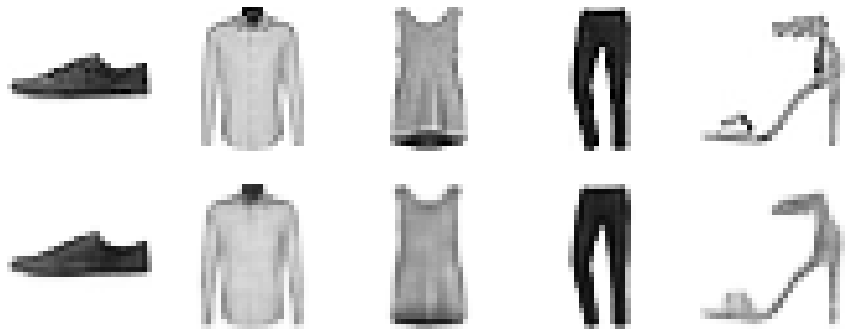

In [12]:
n_epochs = 50
for epoch in range(n_epochs):
    for batch, train_x in enumerate(train_dataset):
        model.train(train_x)
    loss = []
    for batch, test_x in enumerate(test_dataset):
        loss.append(model.compute_loss(train_x))
    losses.loc[len(losses)] = np.mean(loss, axis=0)
    display.clear_output()
    print("Epoch: {} | MSE: {}".format(epoch, losses.MSE.values[-1]))
    plot_reconstruction(model, example_data)

## 绘制梯度图

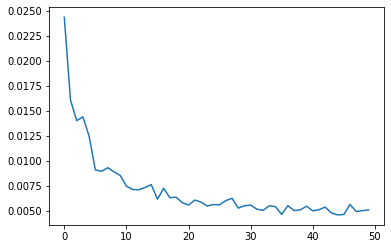

In [13]:
plt.plot(losses.MSE.values)

In [15]:
model.save_weights('./save/save_weights/model_weights.h5')